In [1]:
import pandas as pd
import xgboost as xgb

In [2]:
from sklearn import metrics


In [3]:
import tempfile

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
df = pd.read_csv("/content/drive/MyDrive/Launch Potato - Data Science Manager - data.csv", index_col=0)

In [23]:
df.columns

Index(['campaign', 'keyword', 'keyword_match_type', 'device', 'device_model',
       'page_slug', 'offer_position', 'user_session_count',
       'average_household_income', 'median_age', 'offer_id', 'advertiser_id',
       'card_category', 'date', 'hour', 'approvals', 'payout'],
      dtype='object')

In [24]:
for c in ['campaign', 'keyword', 'keyword_match_type', 'device',
       'device_model', 'page_slug',
          #'offer_position', 'user_session_count',
       'average_household_income', 'median_age', 'offer_id', 'advertiser_id',
       'card_category',
          #'date',
          'hour',
          #'approvals', 'payout']
]:
  df[c] = df[c].astype("category")

In [25]:
# prompt: convert df date column to timestamp and print a summary table

df['date'] = pd.to_datetime(df['date'])

# Print a summary table of the DataFrame
df['date'].value_counts().sort_index()


date
2023-10-07    145
2023-10-08    145
2023-10-09    102
2023-10-10     98
2023-10-11    102
             ... 
2024-03-30    172
2024-03-31    145
2024-04-01    244
2024-04-02    215
2024-04-03     42
Name: count, Length: 180, dtype: int64

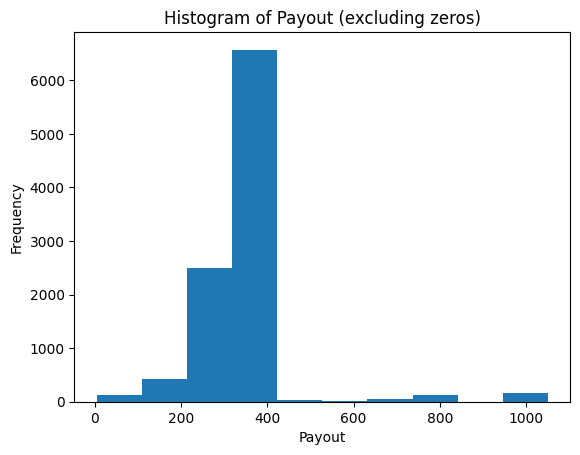

In [8]:
# prompt: create histograms of payout, excluding zeros

import matplotlib.pyplot as plt

# Filter out rows where payout is zero
df_filtered = df[df['payout'] > 0]

# Create a histogram of the payout column
plt.hist(df_filtered['payout'], bins=10)

# Add labels and title
plt.xlabel('Payout')
plt.ylabel('Frequency')
plt.title('Histogram of Payout (excluding zeros)')

# Show the plot
plt.show()


In [10]:
# prompt: create a cross-tab of approvals

df['approvals'].value_counts().to_frame().reset_index().rename(columns={'index':'approvals', 'approvals':'count'})


,count,count
0,0,71378
1,1,9830


In [25]:
# prompt: show min, mean, max of payout by approval status

df_grouped = df.groupby('approvals')['payout'].agg(['min', 'mean', 'max'])
print(df_grouped)


           min        mean     max
approvals                         
0          0.0    0.429999   285.0
1          5.0  335.010376  1050.0


In [30]:
# prompt: what percent of approvals = 0 have payout > 0

df_filtered = df[df['approvals'] == 0]
df_filtered_approvals = df_filtered[df['payout'] > 0]
percent_approvals_0_payout_gt_0 = len(df_filtered_approvals) / len(df_filtered) * 100
print(percent_approvals_0_payout_gt_0)


0.2269606881672224


<ipython-input-30-5cf4d85be03b>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_approvals = df_filtered[df['payout'] > 0]


In [11]:
#df.head()

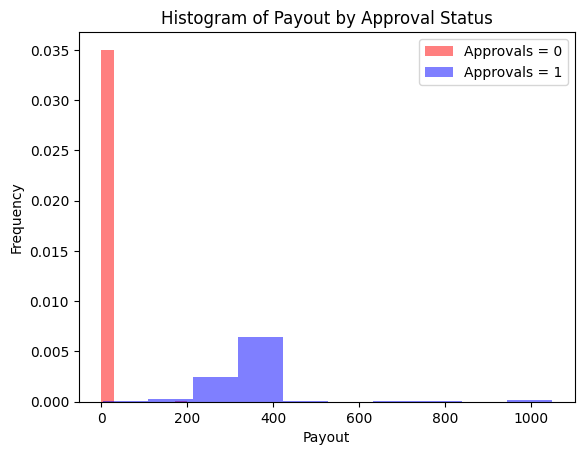

In [41]:
# prompt: show a histogram with approval = 0 in red and approval = 1 in blue

import matplotlib.pyplot as plt

# Filter out rows where payout is zero
df_filtered = df

# Create histograms for approvals 0 and 1
plt.hist(df_filtered[df_filtered['approvals'] == 0]['payout'], bins=10, color='red', alpha=0.5, label='Approvals = 0', density=True)
plt.hist(df_filtered[df_filtered['approvals'] == 1]['payout'], bins=10, color='blue', alpha=0.5, label='Approvals = 1', density=True)

# Add labels and title
plt.xlabel('Payout')
plt.ylabel('Frequency')
plt.title('Histogram of Payout by Approval Status')
plt.legend()

# Show the plot
plt.show()


In [20]:
df['section'] = pd.util.hash_pandas_object(df) % 10
df['split'] = "train"
df.loc[df['section'] == 8, "split"] = "test"
df.loc[df['section'] == 9, "split"] = "val"
df.loc[df['date'] >= '2024-04-01', "split"] = "oot"

In [21]:
df['split'].value_counts()

split
train    63643
test      9279
val       7785
oot        501
Name: count, dtype: int64

In [ ]:
import hyperopt

In [82]:
# prompt: create a hyperopt skeleton for optimizing an xgboost model

import hyperopt
from hyperopt import hp
import time


TARGET = None  #'approvals'
OBJ = None # 'binary:logistic'
MODEL = None # xgb
def objective(params):
  params = {
      'learning_rate': params['learning_rate'],
      'max_depth': int(params['max_depth']),
      'min_child_weight': params['min_child_weight'],
      'subsample': params['subsample'],
      'colsample_bytree': params['colsample_bytree'],
      'n_estimators': int(params['n_estimators']),
      'objective': OBJ,
      'seed': int(params['seed'])
  }

  train = (df[df['split'] == 'train'])
  X_train = train.drop(['approvals' if TARGET == 'approvals' else 'payout', 'payout', 'split', 'section', 'date'], axis=1)
  y_train = train[TARGET].values


  model = MODEL(**params, enable_categorical=True, tree_method='hist')
  model.fit(X_train, y_train)


  out = tempfile.mktemp(".json")
  model.save_model(out)

  val = (df[df['split'] == 'val'])
  X_val = val.drop(['approvals' if TARGET == 'approvals' else 'payout', 'payout', 'split', 'section', 'date'], axis=1)
  y_val = val[TARGET].values

  tic = time.time()
  if OBJ == 'binary:logistic' :
    y_pred = model.predict_proba(X_val)[:, 1]
    score = -metrics.roc_auc_score(y_val, y_pred)
  else :
    y_pred = model.predict(X_val)
    score = metrics.mean_absolute_error(y_val, y_pred)
  toc = time.time()

  return {'loss': score, 'status': hyperopt.STATUS_OK, #'model': model,
          'params': params, 'out':out, 'scoring_time': toc - tic}

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'max_depth': hp.randint('max_depth', 3, 10),
    'min_child_weight': hp.uniform('min_child_weight', 0.1, 1),
    'subsample': hp.uniform('subsample', 0.2, 0.8),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 0.8),
    'n_estimators': hp.quniform('n_estimators', 30, 1000, 10),
    'seed': hp.randint('seed', 2,5),
}


In [72]:

TARGET =  'approvals'
OBJ =   'binary:logistic'
MODEL = xgb.XGBClassifier
trials = hyperopt.Trials()
best = hyperopt.fmin(
    fn=objective,
    space=space,
    algo=hyperopt.tpe.suggest,
    max_evals=30, #TODO increase
    trials=trials
)

print(best)


100%|██████████| 30/30 [06:28<00:00, 12.95s/trial, best loss: -0.6447989623375467]
{'colsample_bytree': 0.21195289418716431, 'learning_rate': 0.010362276077679826, 'max_depth': 8, 'min_child_weight': 0.8042095944023444, 'n_estimators': 990.0, 'seed': 3, 'subsample': 0.21410785337861024}


In [73]:
trials.best_trial

{'state': 2,
 'tid': 24,
 'spec': None,
 'result': {'loss': -0.6447989623375467,
  'status': 'ok',
  'params': {'learning_rate': 0.010362276077679826,
   'max_depth': 8,
   'min_child_weight': 0.8042095944023444,
   'subsample': 0.21410785337861024,
   'colsample_bytree': 0.21195289418716431,
   'n_estimators': 990,
   'objective': 'binary:logistic',
   'seed': 3},
  'out': '/tmp/tmp217tj4gp.json',
  'scoring_time': 0.4288008213043213},
 'misc': {'tid': 24,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [24],
   'learning_rate': [24],
   'max_depth': [24],
   'min_child_weight': [24],
   'n_estimators': [24],
   'seed': [24],
   'subsample': [24]},
  'vals': {'colsample_bytree': [0.21195289418716431],
   'learning_rate': [0.010362276077679826],
   'max_depth': [8],
   'min_child_weight': [0.8042095944023444],
   'n_estimators': [990.0],
   'seed': [3],
   'subsample': [0.21410785337861024]}},
 'exp_key': None,
 'owner': None,
 'vers

In [108]:
t = list(trials)

In [110]:
t[0]

{'state': 2,
 'tid': 0,
 'spec': None,
 'result': {'loss': -0.6382017332335437,
  'status': 'ok',
  'params': {'learning_rate': 0.029413601057273066,
   'max_depth': 7,
   'min_child_weight': 0.6198647273451835,
   'subsample': 0.5393902011697604,
   'colsample_bytree': 0.46159015886901655,
   'n_estimators': 120,
   'objective': 'binary:logistic',
   'seed': 3},
  'out': '/tmp/tmpfzodeb6h.json',
  'scoring_time': 0.06459403038024902},
 'misc': {'tid': 0,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [0],
   'learning_rate': [0],
   'max_depth': [0],
   'min_child_weight': [0],
   'n_estimators': [0],
   'seed': [0],
   'subsample': [0]},
  'vals': {'colsample_bytree': [0.46159015886901655],
   'learning_rate': [0.029413601057273066],
   'max_depth': [7],
   'min_child_weight': [0.6198647273451835],
   'n_estimators': [120.0],
   'seed': [3],
   'subsample': [0.5393902011697604]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 

/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/usr/local/lib/python3.10/dist-packages/plotnine/sta

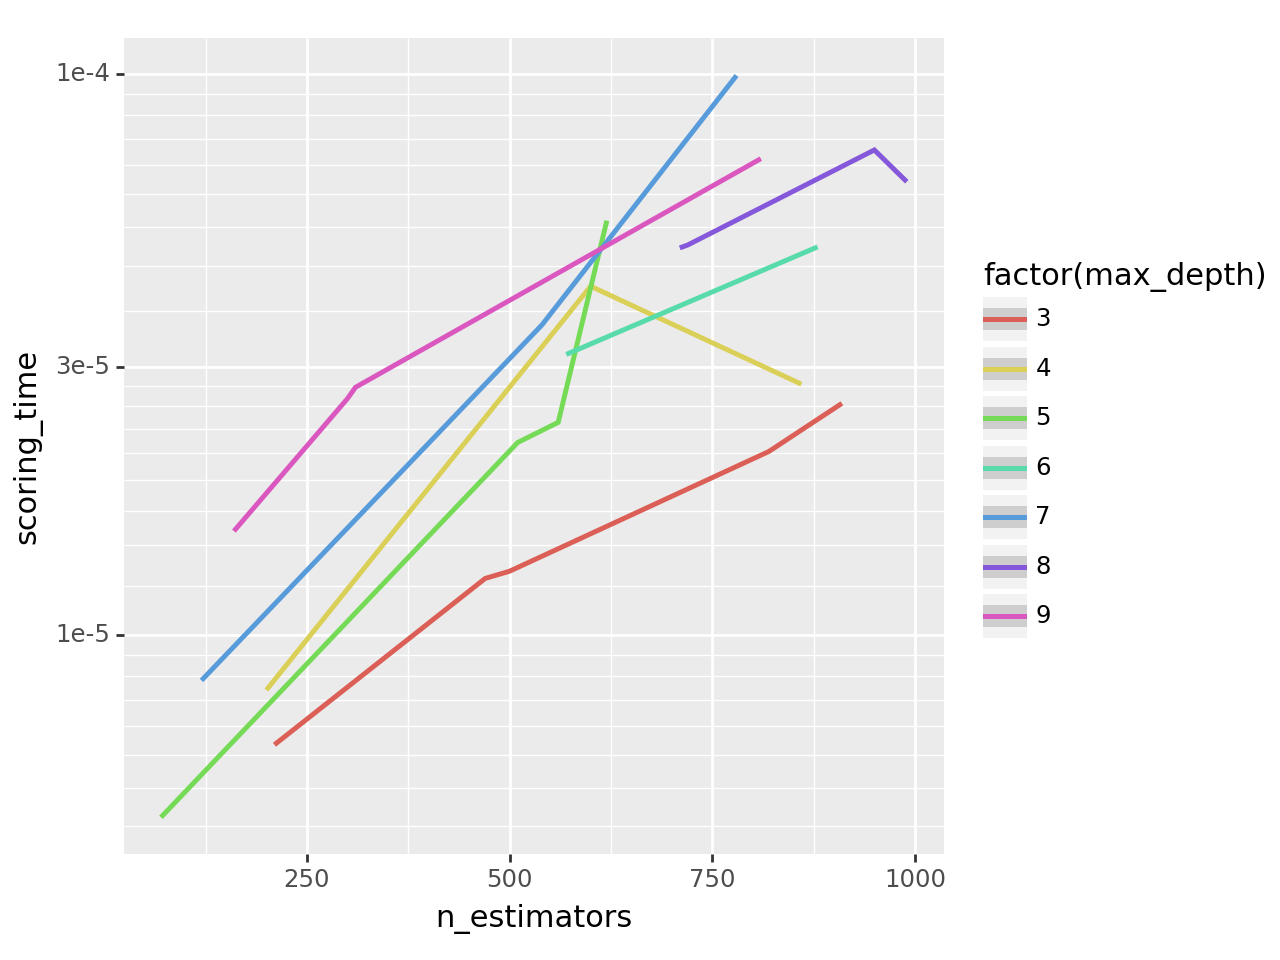

<Figure Size: (640 x 480)>

In [114]:
perf = pd.DataFrame(dict(scoring_time=t['result']['scoring_time'] / 7785, #NB: number of records in val
                         max_depth=t['result']['params']['max_depth'],
                         n_estimators=t['result']['params']['n_estimators']
                         )
          for t in trials)
p9.ggplot(perf) + p9.aes(y="scoring_time", x="n_estimators", color="factor(max_depth)", group="factor(max_depth)") +  p9.geom_smooth() + p9.scale_y_log10()

In [74]:
# prompt: load the xgboost model specified by trials.best_trial['result'][''out']

model = xgb.XGBClassifier(**trials.best_trial['result']['params'], enable_categorical=True, tree_method='hist')
model.load_model(trials.best_trial['result']['out'])


In [75]:
# prompt: make predictions with model on df test section and oot section

test = df[df['split'] == 'test']
X_test = test.drop(['approvals', 'payout', 'split', 'section', 'date'], axis=1)
y_test = test[TARGET].values

oot = df[df['split'] == 'oot']
X_oot = oot.drop(['approvals', 'payout', 'split', 'section', 'date'], axis=1)
y_oot = oot[TARGET].values

y_pred_test = model.predict_proba(X_test)[:, 1]
y_pred_oot = model.predict_proba(X_oot)[:, 1]


In [76]:
# prompt: create a dataframe containing y_test and y_test_actual, round y_test to .1, aggregate by y_test

import pandas as pd
import numpy as np

# Create a dataframe containing y_test and y_test_actual
df_y_test = pd.DataFrame({'y_pred_test': y_pred_test, 'y_test': y_test})

# Round y_test to .1
df_y_test['y_pred_test_rounded'] = np.round(df_y_test['y_pred_test'], 2)

# Aggregate by y_test
df_y_test_agg = df_y_test.groupby('y_pred_test_rounded').agg({'y_test': 'count'}).reset_index()
df_y_test_agg['y_test'] = df_y_test_agg['y_test'].cumsum() / df_y_test_agg['y_test'].sum()

# Print the aggregated dataframe
print(df_y_test_agg)


    y_pred_test_rounded    y_test
0                  0.01  0.000647
1                  0.02  0.006466
2                  0.03  0.029529
3                  0.04  0.068650
4                  0.05  0.119841
5                  0.06  0.174157
6                  0.07  0.234939
7                  0.08  0.300463
8                  0.09  0.367712
9                  0.10  0.432482
10                 0.11  0.493372
11                 0.12  0.560836
12                 0.13  0.626576
13                 0.14  0.686496
14                 0.15  0.741783
15                 0.16  0.794051
16                 0.17  0.834680
17                 0.18  0.869921
18                 0.19  0.894816
19                 0.20  0.918095
20                 0.21  0.934907
21                 0.22  0.951288
22                 0.23  0.963897
23                 0.24  0.973381
24                 0.25  0.979200
25                 0.26  0.985128
26                 0.27  0.989115
27                 0.28  0.991809
28            

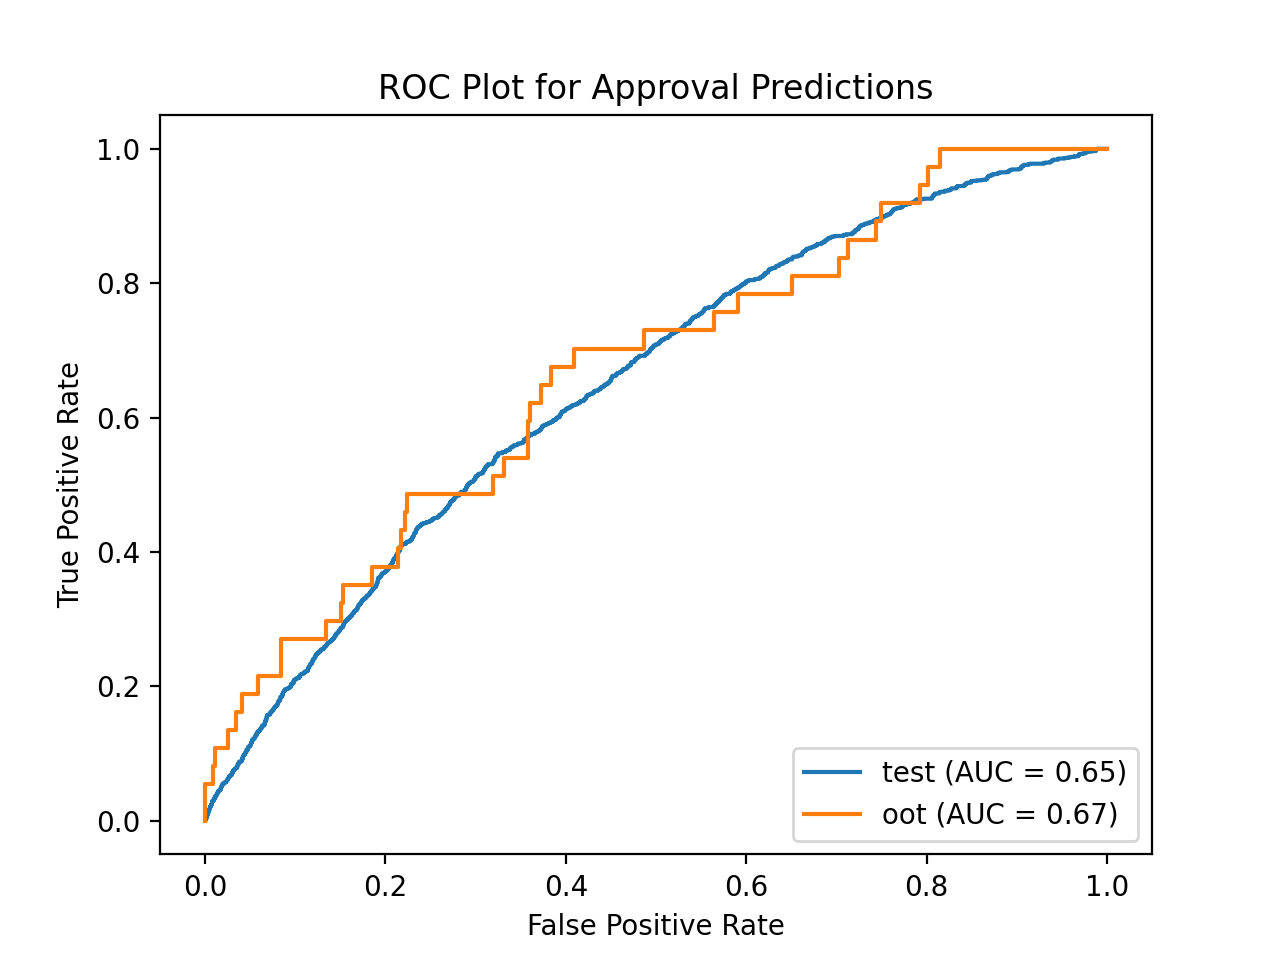

In [94]:
# prompt: create ROC plot using df_y_test dataset

import matplotlib.pyplot as plt
# Import necessary libraries
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Calculate ROC curve and AUC
#fpr, tpr, thresholds = roc_curve()
#roc_auc = auc(fpr, tpr)

# Create ROC plot
RocCurveDisplay.from_predictions(df_y_test['y_test'], df_y_test['y_pred_test'], name='test')
RocCurveDisplay.from_predictions(y_oot, y_pred_oot, ax=plt.gca(), name='oot')


#fpr, tpr, thresholds = roc_curve(y_oot, y_pred_oot)
#RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()


# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Plot for Approval Predictions')

# Show the plot
plt.show()


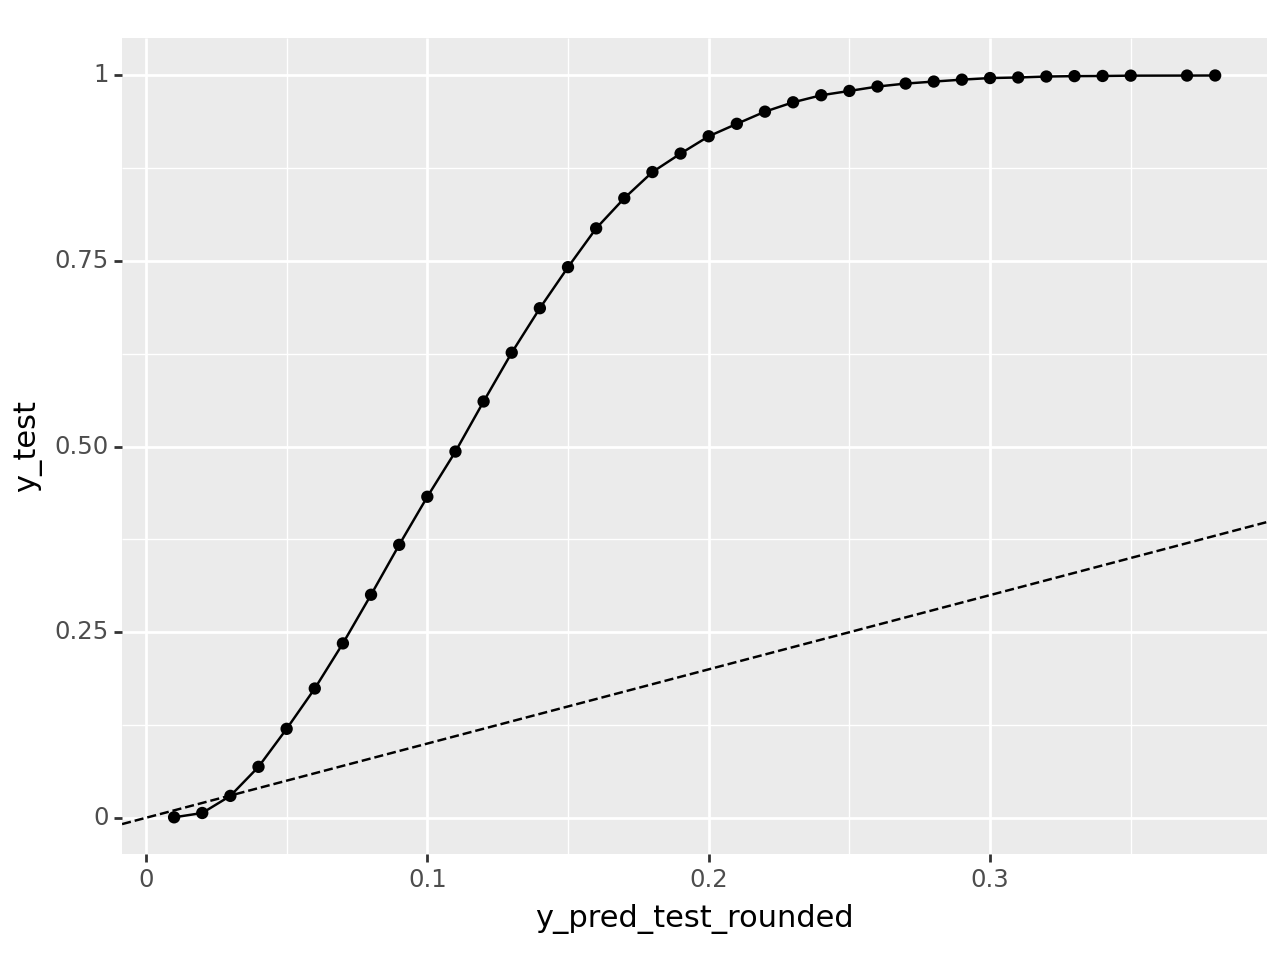

<Figure Size: (640 x 480)>

In [77]:
import plotnine as p9
p9.ggplot(df_y_test_agg) + p9.aes(x="y_pred_test_rounded", y="y_test") + p9.geom_point() + p9.geom_line() + p9.geom_abline(intercept=0, slope=1, linetype='dashed')

In [83]:
TARGET = 'payout'
OBJ = 'reg:squarederror'
MODEL = xgb.XGBRegressor
trials_reg = hyperopt.Trials()
best = hyperopt.fmin(
    fn=objective,
    space=space,
    algo=hyperopt.tpe.suggest,
    max_evals=30, #TODO increase
    trials=trials_reg
)

print(best)


100%|██████████| 30/30 [05:36<00:00, 11.22s/trial, best loss: 5.060349534052717]
{'colsample_bytree': 0.6397314654939642, 'learning_rate': 0.03301072258814482, 'max_depth': 6, 'min_child_weight': 0.4369919957299132, 'n_estimators': 940.0, 'seed': 4, 'subsample': 0.6127312548719477}


In [97]:
trials_reg.best_trial

{'state': 2,
 'tid': 29,
 'spec': None,
 'result': {'loss': 5.060349534052717,
  'status': 'ok',
  'params': {'learning_rate': 0.03301072258814482,
   'max_depth': 6,
   'min_child_weight': 0.4369919957299132,
   'subsample': 0.6127312548719477,
   'colsample_bytree': 0.6397314654939642,
   'n_estimators': 940,
   'objective': 'reg:squarederror',
   'seed': 4},
  'out': '/tmp/tmp38qygx2f.json',
  'scoring_time': 0.3852248191833496},
 'misc': {'tid': 29,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [29],
   'learning_rate': [29],
   'max_depth': [29],
   'min_child_weight': [29],
   'n_estimators': [29],
   'seed': [29],
   'subsample': [29]},
  'vals': {'colsample_bytree': [0.6397314654939642],
   'learning_rate': [0.03301072258814482],
   'max_depth': [6],
   'min_child_weight': [0.4369919957299132],
   'n_estimators': [940.0],
   'seed': [4],
   'subsample': [0.6127312548719477]}},
 'exp_key': None,
 'owner': None,
 'version': 0

In [85]:

regmodel = MODEL(**trials_reg.best_trial['result']['params'], enable_categorical=True, tree_method='hist')
regmodel.load_model(trials_reg.best_trial['result']['out'])


In [86]:
regmodel = MODEL(enable_categorical=True)
regmodel.load_model(trials_reg.best_trial['result']['out'])


In [126]:
print(TARGET)
test = df[df['split'] == 'test']
X_test = test.drop(['payout', 'split', 'section', 'date'], axis=1)
y_test_r = test[TARGET].values

oot = df[df['split'] == 'oot']
X_oot = oot.drop(['payout',  'split', 'section', 'date'], axis=1)
y_oot_r = oot[TARGET].values

y_pred_test_r = regmodel.predict(X_test)
y_pred_oot_r = regmodel.predict(X_oot)

payout


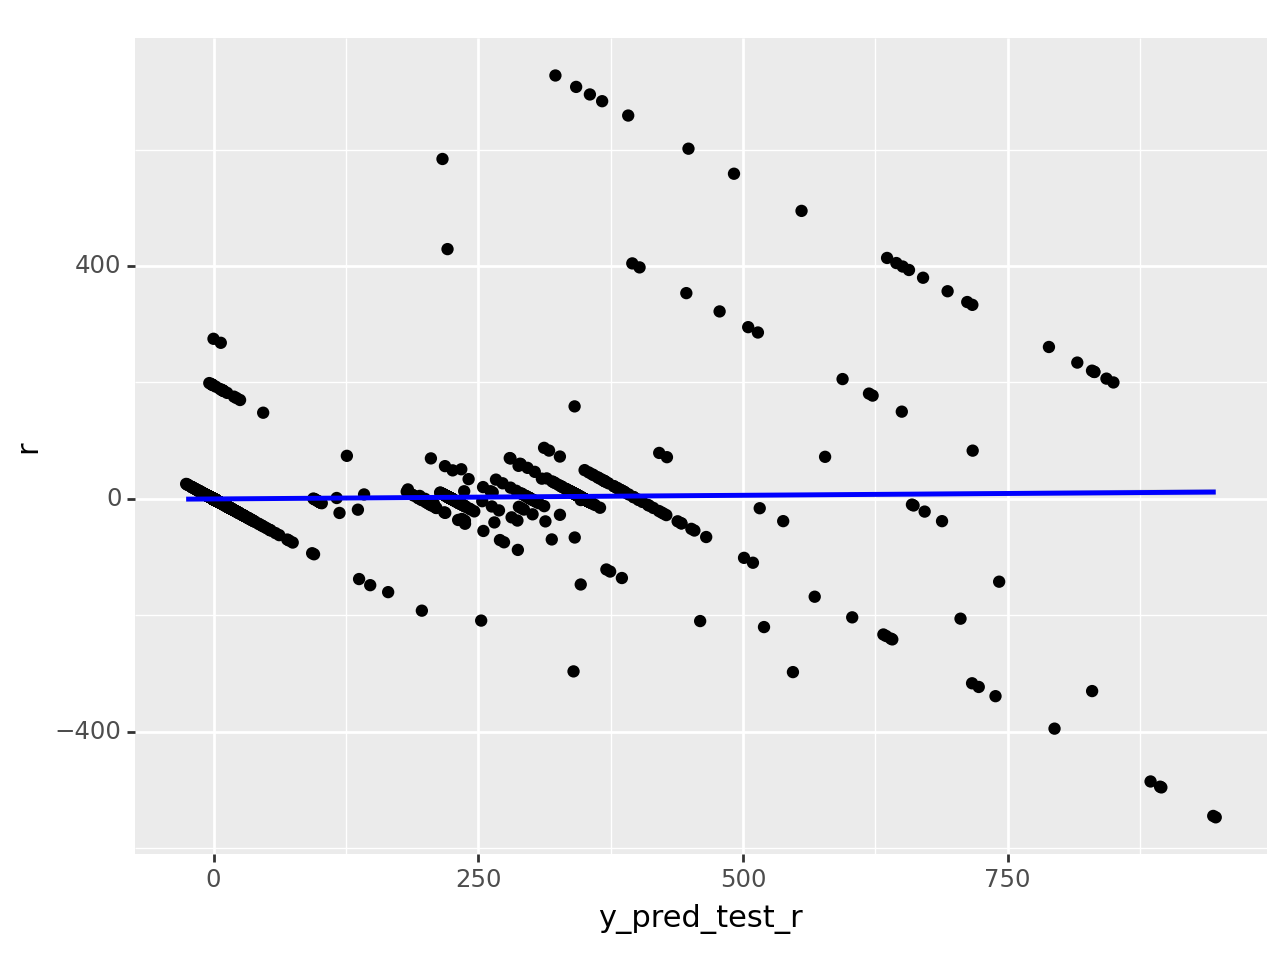

<Figure Size: (640 x 480)>

In [127]:
p9.ggplot(pd.DataFrame(dict(r=y_test_r - y_pred_test_r, pred=y_pred_test_r))) + p9.aes(y="r", x="y_pred_test_r") + p9.geom_point() + p9.geom_smooth(color='blue')

/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/usr/local/lib/python3.10/dist-packages/plotnine/sta

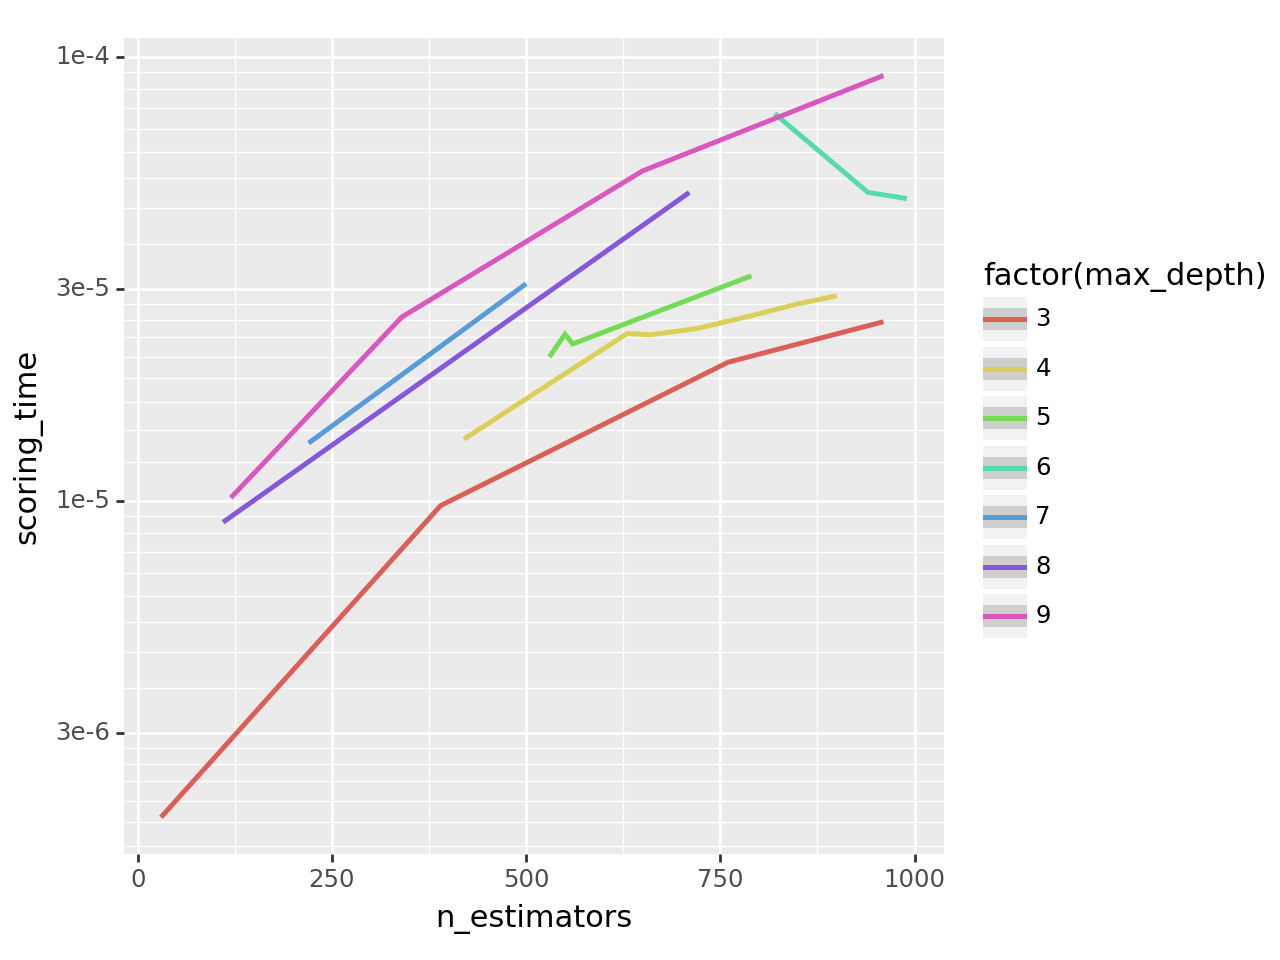

<Figure Size: (640 x 480)>

In [128]:
perf = pd.DataFrame(dict(scoring_time=t['result']['scoring_time'] / 7785, #NB: number of records in val
                         max_depth=t['result']['params']['max_depth'],
                         n_estimators=t['result']['params']['n_estimators']
                         )
          for t in trials_reg)
p9.ggplot(perf) + p9.aes(y="scoring_time", x="n_estimators", color="factor(max_depth)", group="factor(max_depth)") +  p9.geom_smooth() + p9.scale_y_log10()

In [235]:
df_test_combo = X_test.copy()
df_test_combo['date'] = test['date']
df_test_combo['payout'] = test['payout']

df_test_combo['y_a'] = model.predict_proba(X_test.drop(columns=['approvals']))[:, 1]

X_test['approvals'] = 0
df_test_combo['e_a0'] = regmodel.predict(X_test)

X_test['approvals'] = 1
df_test_combo['e_a1'] = regmodel.predict(X_test)
df_test_combo['e_a1_m_e_a0'] = df_test_combo['e_a1'] - df_test_combo['e_a0']



#df_test_combo['e_a0'] = y_pred_test_r = regmodel.predict(X_test.transform(lambda x: x['approved'].apply()))


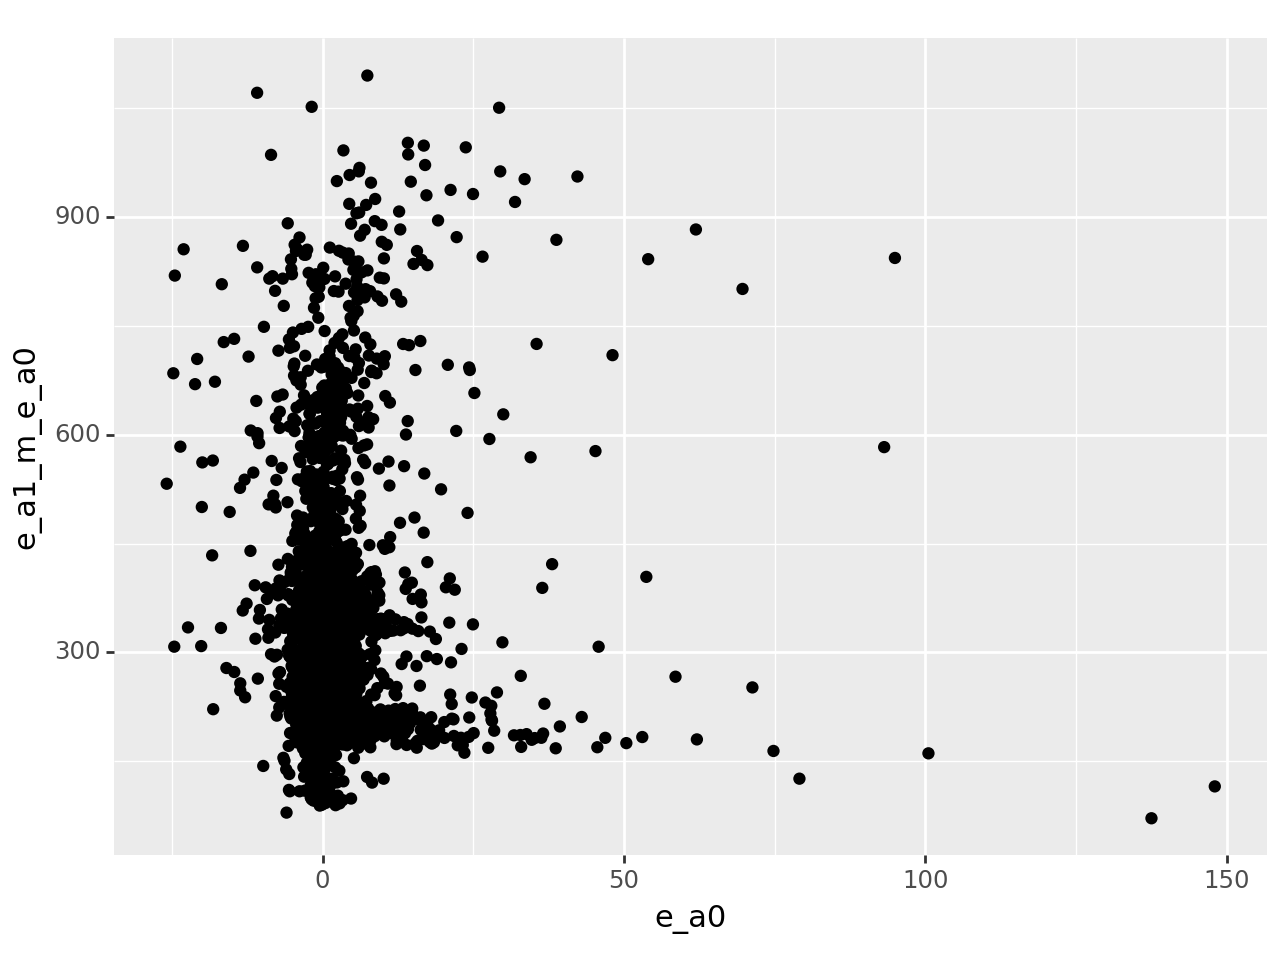

<Figure Size: (640 x 480)>

In [236]:
p9.ggplot(df_test_combo) + p9.aes(x="e_a0", y="e_a1_m_e_a0") + p9.geom_point()

In [249]:
df_test_combo['E'] = df_test_combo['e_a1'] * (df_test_combo["y_a"]) +  df_test_combo['e_a0'] * (1 - df_test_combo["y_a"])


In [250]:
df_test_combo['week'] = df_test_combo['date'].dt.to_period('W')


In [253]:
df_test_week = df_test_combo.groupby("week").agg({"payout":"sum", "E":"sum"}).reset_index()
df_test_week['r'] = df_test_week['payout'] - df_test_week['E']


/usr/local/lib/python3.10/dist-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_x_datetime could not recognise parameter `label`


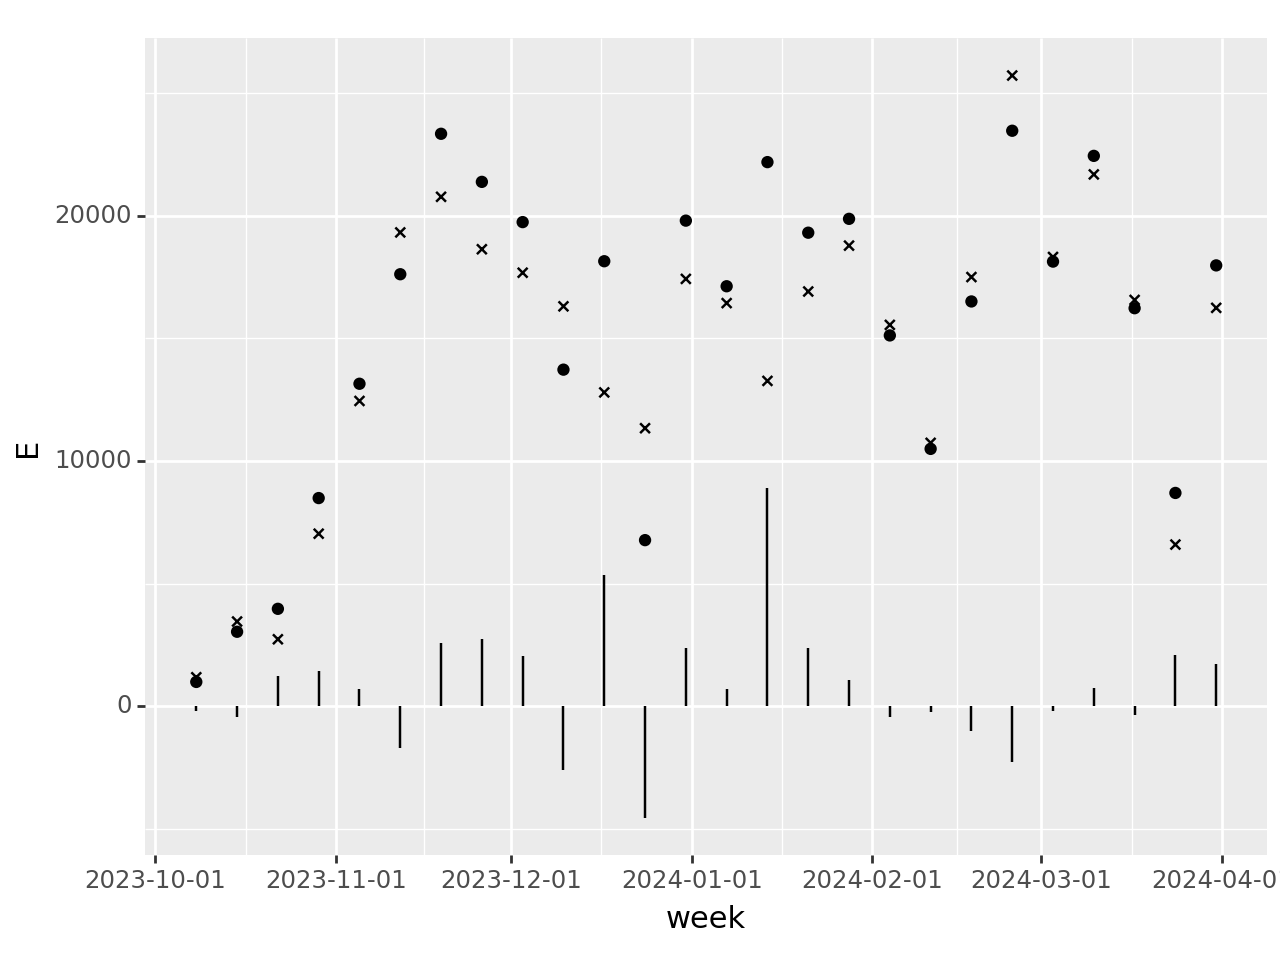

<Figure Size: (640 x 480)>

In [263]:


p9.ggplot(df_test_week) + p9.aes(x="week") + p9.geom_point(p9.aes( y="E"), shape='x') + p9.geom_point(p9.aes( y="payout"), shape='o')  +\
p9.geom_segment(p9.aes( y="r", xend='week'),yend=0) + p9.scale_x_date( label=None)

In [265]:
from google.colab import files
files.download(trials.best_trial['result']['out'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [266]:
from google.colab import files
files.download(trials_reg.best_trial['result']['out'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
fname = tempfile.mktemp(".pkl")
df.head(1).to_pickle(fname)

In [42]:
from google.colab import files
files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>